# Single-shot denoising for simulated data

Use dncnn with kernelpredicting to denoise simulated data.
We demonstrate that a deep neural net can be trained to denoise a single noisy image, taking advantage of the fact that one 512 x 512 image contains ~250,000 dimensions of information.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise
from skimage.measure import compare_psnr

In [5]:
from skimage.io import imread, imsave
plt.rc('figure', figsize = (5,5))

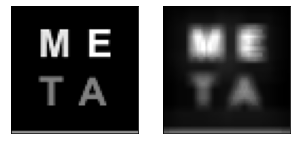

In [6]:
from skimage import transform
from skimage import data, img_as_float, img_as_ubyte
image = imread('../figs/origin_meta.bmp')#numpy
image = img_as_float(image)
noisy_image = imread('../figs/blurred_meta.bmp')#numpy
noisy_image = img_as_float(noisy_image)
plt.subplot(1,2,1)
show(image)
plt.subplot(1,2,2)
show(noisy_image)

In [7]:
import torch
noisy = torch.Tensor(noisy_image[np.newaxis, np.newaxis])
#image = torch.Tensor(image[np.newaxis, np.newaxis])#input & output cant use same name
print(noisy.shape)

torch.Size([1, 1, 60, 60])


In [ ]:
#plot_tensors([noisy, clean])

# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [8]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

# Model

For our model, we use a dncnn with kernelpredicting.

In [9]:
from models.babyunet import BabyUnet
from models.unet import Unet
from models.dncnn import DnCNN, DnCNNKernel, ResCNN

from models.kernelpredicting import KernelPredicting

model = DnCNNKernel(1, num_of_layers = 8)
# model = ResCNN(1, 32, 8)
#model = KernelPredicting(1, DnCNN, kernel_width=15,
#                         depth= 6,
#                          features= 32)

In [10]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

17760

In [ ]:
#image.ravel().shape

# Training

In [11]:
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [12]:
noisy.shape

torch.Size([1, 1, 60, 60])

In [13]:
losses = []
val_losses = []
best_images = []
best_val_loss = 1


for i in range(500):
    model.train()
    
    net_input, mask = masker.mask(noisy, i%(masker.n_masks-1))
    net_output = model(net_input)
    #print(net_output.shape)
    #print(noisy.shape)
    
    loss = loss_function(net_output*mask, noisy*mask)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    losses.append(loss.item())
    
    if i % 5 == 0:
        losses.append(loss.item())
        model.eval()
        
        net_input, mask = masker.mask(noisy, masker.n_masks - 1)
        net_output = model(net_input)
    
        val_loss = loss_function(net_output*mask, noisy*mask)
        
        val_losses.append(val_loss.item())
        
        print("(", i, ") Loss: \t", round(loss.item(), 5), "\tVal Loss: \t", round(val_loss.item(), 5))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            denoised = np.clip(model(noisy).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
            #print(denoised.shape)
            #print(image.shape)
            best_psnr = compare_psnr(denoised, image)
            best_images.append(denoised)
            print("\tModel PSNR: ", np.round(best_psnr, 2))

( 0 ) Loss: 	 6e-05 	Val Loss: 	 0.00036
(60, 60)
(60, 60)
	Model PSNR:  14.5
( 5 ) Loss: 	 2e-05 	Val Loss: 	 0.0003
(60, 60)
(60, 60)
	Model PSNR:  14.57
( 10 ) Loss: 	 2e-05 	Val Loss: 	 9e-05
(60, 60)
(60, 60)
	Model PSNR:  14.77


/home/disk/disk1/LiuTQ/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


( 15 ) Loss: 	 2e-05 	Val Loss: 	 3e-05
(60, 60)
(60, 60)
	Model PSNR:  14.89
( 20 ) Loss: 	 1e-05 	Val Loss: 	 3e-05
(60, 60)
(60, 60)
	Model PSNR:  14.91
( 25 ) Loss: 	 1e-05 	Val Loss: 	 4e-05
( 30 ) Loss: 	 2e-05 	Val Loss: 	 4e-05
( 35 ) Loss: 	 1e-05 	Val Loss: 	 3e-05
( 40 ) Loss: 	 1e-05 	Val Loss: 	 3e-05
(60, 60)
(60, 60)
	Model PSNR:  14.96
( 45 ) Loss: 	 1e-05 	Val Loss: 	 3e-05
(60, 60)
(60, 60)
	Model PSNR:  14.97
( 50 ) Loss: 	 1e-05 	Val Loss: 	 3e-05
(60, 60)
(60, 60)
	Model PSNR:  14.96
( 55 ) Loss: 	 1e-05 	Val Loss: 	 3e-05
( 60 ) Loss: 	 1e-05 	Val Loss: 	 3e-05
( 65 ) Loss: 	 1e-05 	Val Loss: 	 3e-05
(60, 60)
(60, 60)
	Model PSNR:  14.95
( 70 ) Loss: 	 1e-05 	Val Loss: 	 2e-05
(60, 60)
(60, 60)
	Model PSNR:  14.92
( 75 ) Loss: 	 1e-05 	Val Loss: 	 3e-05
( 80 ) Loss: 	 1e-05 	Val Loss: 	 3e-05
( 85 ) Loss: 	 1e-05 	Val Loss: 	 3e-05
( 90 ) Loss: 	 1e-05 	Val Loss: 	 2e-05
(60, 60)
(60, 60)
	Model PSNR:  14.96
( 95 ) Loss: 	 1e-05 	Val Loss: 	 2e-05
(60, 60)
(60, 60

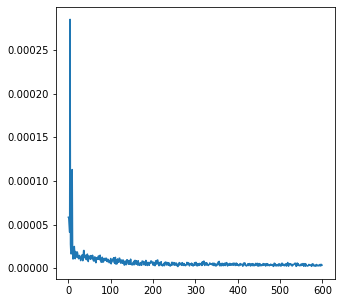

In [14]:
plt.plot(losses)

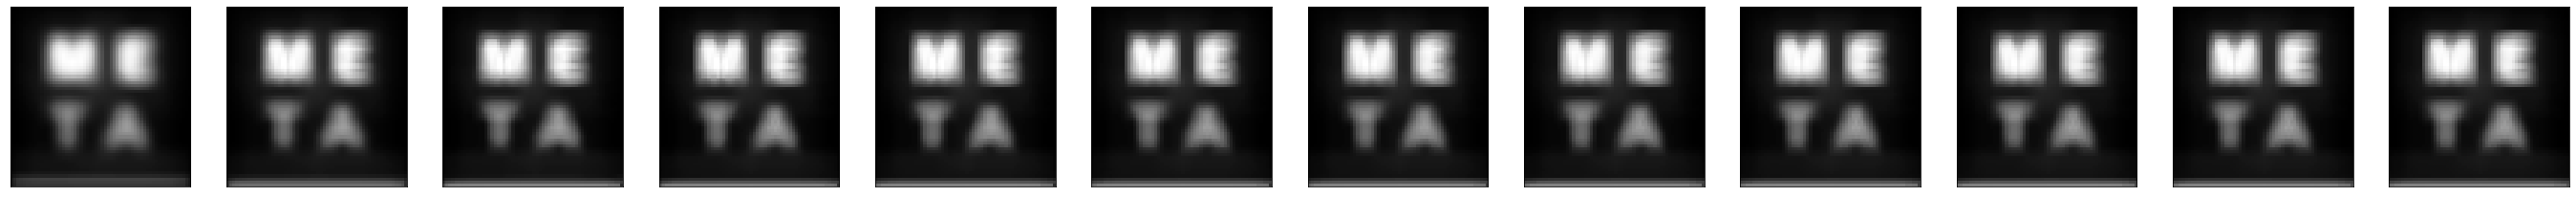

In [15]:
plot_images(best_images[::2])

In [16]:
denoised = best_images[-1]
#print(denoised)

In [17]:
compare_psnr(denoised, image)

/home/disk/disk1/LiuTQ/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.


14.935560594513035

torch.Size([1, 1, 60, 60])
torch.Size([1, 1, 60, 60])
torch.Size([1, 1, 60, 60])


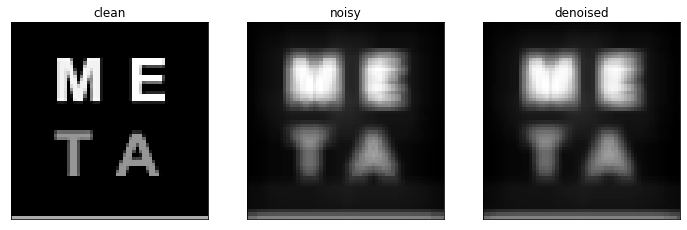

In [19]:
image_ = torch.Tensor(image[np.newaxis, np.newaxis])
denoised_ = torch.Tensor(denoised[np.newaxis, np.newaxis])
print(image_.shape)
print(denoised_.shape)
print(noisy.shape)
plot_tensors([image_, noisy, denoised_],["clean", "noisy", "denoised"])